conda: pytorch_playground

In [1]:
import torch, torchvision
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

torch.set_printoptions(linewidth=120)

# Import model

In [2]:
import models
model = models.CNN()
model.load_state_dict(torch.load("model_folder/model_2_best_1.pt"))

<All keys matched successfully>

# Import data

In [3]:
T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_data_train = torchvision.datasets.MNIST('mnist_data',
                                              transform=T,
                                              download=True, 
                                              train=True)
mnist_data_valid = torchvision.datasets.MNIST('mnist_data',
                                             transform=T,
                                             download=True, 
                                             train=False)
emnist_data_train = torchvision.datasets.EMNIST('emnist_data',
                                               split = "balanced",
                                               transform=T,
                                               download=True,
                                               train=True)
emnist_data_valid = torchvision.datasets.EMNIST('emnist_data',
                                               split = "balanced",
                                               transform=T,
                                               download=True,
                                               train=False)

In [4]:
target = list(range(10))
target

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Batch

In [242]:
bs = 128
mnist_dataloader_train = torch.utils.data.DataLoader(mnist_data_train, batch_size=bs)
mnist_dataloader_valid = torch.utils.data.DataLoader(mnist_data_valid, batch_size=bs)
emnist_dataloader_train = torch.utils.data.DataLoader(emnist_data_train, batch_size=bs)
emnist_dataloader_valid = torch.utils.data.DataLoader(emnist_data_valid, batch_size=bs)

m_batch = next(iter(mnist_dataloader_train))
m_images, m_labels = m_batch

e_batch = next(iter(emnist_dataloader_train))
e_images, e_labels = e_batch

In [244]:
len(mnist_dataloader_train)

469

In [246]:
mnist_data_valid_1, mnist_data_valid_2 = torch.utils.data.random_split(mnist_data_valid, 
                                                                       [5000, 5000])
mnist_dataloader_valid_1 = torch.utils.data.DataLoader(mnist_data_valid_1, batch_size=bs)
mnist_dataloader_valid_2 = torch.utils.data.DataLoader(mnist_data_valid_2, batch_size=bs)

# MC_dropout

In [6]:
# batch = m_batch
# images, labels = batch

In [7]:
# images.shape

In [8]:
# model.eval()
# with torch.no_grad():
#     preds_eval = model(images)

# model.train()
# preds_eval_s = F.softmax(preds_eval, dim=1)

In [9]:
# n = 1000
# mc_list = []
# with torch.no_grad():
#     for i in range(n):
#         preds = model(images)
#         mc_list.append(preds.unsqueeze(dim=1))

In [10]:
# mc = torch.cat((mc_list), dim=1)
# mc_s = F.softmax(mc, dim=2)
# mc.shape

In [11]:
# img = 0
# mc_s[img].sum()

In [12]:
# mc.mean(dim=1).argmax(dim=1)

In [13]:
# plt.imshow(images[img].squeeze(), cmap = "gray")
# print("label:", labels[img])

In [14]:
# sns.stripplot(target, preds_eval[img], jitter=0)\
#     .set_title("Standard - Pre-softmax")

In [15]:
# sns.stripplot(target, preds_eval_s[img], jitter=0)\
#     .set_title("Standard - Pre-softmax")

In [16]:
# sns.stripplot(target*n, mc[img].reshape(mc[img].numel()), jitter=0.3)\
#     .set_title("MC_dropout - Pre-softmax")

In [17]:
# fig_mc_s = sns.stripplot(target*n, mc_s[img].reshape(mc_s[img].numel()), jitter=0.3)\
#     .set_title("MC_dropout - Softmax")

In [18]:
# fig_mc_b = sns.boxplot(target*n, mc_s[img].reshape(mc_s[img].numel()))
# fig_mc_b.set_title("MC_dropout - Softmax")

In [19]:
# fig_mc_b

# FINAL TRY?

## SET: n

In [20]:
n = 200

In [21]:
batch = m_batch
images, labels = batch

In [22]:
model.eval()
with torch.no_grad():
    preds_eval = model(images)

model.train()
preds_eval_s = F.softmax(preds_eval, dim=1)

In [23]:
mc_list = []
with torch.no_grad():
    for i in range(n):
        preds = model(images)
        mc_list.append(preds.unsqueeze(dim=2))

In [24]:
mc = torch.cat((mc_list), dim=2)
mc_s = F.softmax(mc, dim=1)
# mc_s[img].sum() # =n
mc.shape

torch.Size([2000, 10, 200])

### GET MC VALUES

In [25]:
# np.percentile(mc_s[0][4], [0, 25, 50, 75, 100])

In [26]:
mc_s.shape

torch.Size([2000, 10, 200])

In [27]:
image_values = []
for _image in mc_s:
    target_values = []
    for _target in _image:
        target_values.append(_target.mean())
        target_values.append(_target.std())
    image_values.append(target_values)
mc_tensor = torch.tensor(image_values)
mc_tensor.shape

torch.Size([2000, 20])

In [28]:
model.eval()
with torch.no_grad():
    preds_eval = model(images)

model.train()
preds_eval_s = F.softmax(preds_eval, dim=1)

In [29]:
mc_labels = preds_eval_s.argmax(dim=1).eq(labels).type_as(preds_eval_s)

In [30]:
mc_features = torch.cat((mc_tensor, preds_eval_s), dim=1)
mc_features.shape

torch.Size([2000, 30])

### Now add letters to the training data

In [31]:
batch_e = e_batch
images_e, labels_e = batch_e

model.eval()
with torch.no_grad():
    preds_eval_e = model(images_e)

model.train()
preds_eval_s_e = F.softmax(preds_eval_e, dim=1)

mc_list_e = []
with torch.no_grad():
    for i in range(n):
        preds_e = model(images_e)
        mc_list_e.append(preds_e.unsqueeze(dim=2))
        
mc_e = torch.cat((mc_list_e), dim=2)
mc_s_e = F.softmax(mc_e, dim=1)
# mc_s[img].sum() # =n
mc_e.shape

torch.Size([2000, 10, 200])

In [32]:
image_values_e = []
for _image_e in mc_s_e:
    target_values_e = []
    for _target_e in _image_e:
        target_values_e.append(_target_e.mean())
        target_values_e.append(_target_e.std())
    image_values_e.append(target_values_e)
mc_tensor_e = torch.tensor(image_values_e)
mc_tensor_e.shape

torch.Size([2000, 20])

In [33]:
# mc_labels_e = preds_eval_s.argmax(dim=1).eq(labels).type_as(preds_eval_s)
# mc_labels_e.shape

In [34]:
# mc_labels_e = [0] * preds_eval_s.shape[0]
mc_labels_e = torch.zeros(2000)

In [75]:
mc_features_e = torch.cat((mc_tensor_e, preds_eval_s), dim=1)
mc_features_e.shape

torch.Size([2000, 30])

In [76]:
mc_features_e.eq(mc_features)

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

In [77]:
mc_features_e[0]

tensor([2.0085e-01, 2.4631e-01, 9.1439e-03, 2.0030e-02, 2.9400e-02, 5.8536e-02, 3.4959e-02, 7.4431e-02, 2.6215e-04,
        7.5067e-04, 3.5401e-02, 7.4682e-02, 1.8526e-03, 6.0293e-03, 1.1861e-01, 1.7756e-01, 5.6098e-01, 3.0092e-01,
        8.5476e-03, 1.6193e-02, 1.5256e-05, 4.6124e-06, 1.2589e-04, 9.9573e-02, 2.0898e-08, 8.9929e-01, 1.1836e-05,
        3.9326e-07, 9.0154e-04, 7.5405e-05])

In [78]:
mc_features

tensor([[2.3359e-03, 2.0910e-02, 3.6155e-04,  ..., 3.9326e-07, 9.0154e-04, 7.5405e-05],
        [9.9689e-01, 1.7945e-02, 9.2075e-06,  ..., 1.7761e-06, 1.8000e-07, 3.4120e-06],
        [5.9406e-05, 2.5909e-04, 1.6620e-03,  ..., 5.4842e-05, 1.6413e-07, 1.0117e-03],
        ...,
        [2.1101e-03, 2.3733e-02, 1.6087e-04,  ..., 5.7707e-11, 3.6466e-04, 2.9351e-05],
        [3.7244e-03, 1.1267e-02, 1.1225e-02,  ..., 2.2056e-02, 1.5924e-02, 7.4251e-04],
        [5.7771e-01, 2.9599e-01, 1.5291e-03,  ..., 5.1271e-05, 1.0898e-02, 1.1034e-02]])

### PLOT

In [79]:
targets = []
for i in range(10):
    for _ in range(n):
        targets.append(i)

In [192]:
img = 2

Text(0.5, 1.0, 'MC_dropout - Softmax')

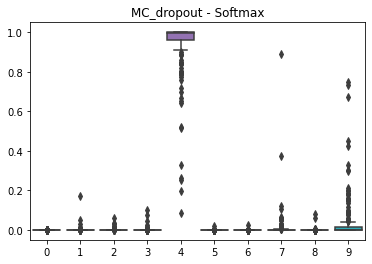

In [193]:
fig_mc_b = sns.boxplot(targets, mc_s[img].reshape(mc_s[img].numel()))
fig_mc_b.set_title("MC_dropout - Softmax")

In [82]:
mc_s_e.shape

torch.Size([2000, 10, 200])

Text(0.5, 1.0, 'MC_dropout - Softmax - e')

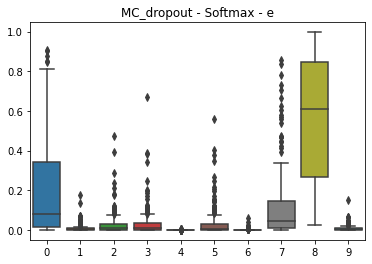

In [83]:
fig_mc_b_e = sns.boxplot(targets, mc_s_e[img].reshape(mc_s_e[img].numel()))
fig_mc_b_e.set_title("MC_dropout - Softmax - e")

# Combine MNIST and EMNIST data

In [84]:
X = torch.cat((mc_features, mc_features_e))
y = torch.cat((mc_labels, mc_labels_e))

In [85]:
X.shape

torch.Size([4000, 30])

In [86]:
y.shape

torch.Size([4000])

In [87]:
# y = np.array(y, dtype=int)
one = 0
zero = 0
for i in y:
    if i == 1:
        one += 1
    if i == 0:
        zero += 1
one, zero

(1953, 2047)

### Only extract 2 highest probabilities with its stdev

In [88]:
index = reversed(X[0][20:30].argsort())[:2]

eval probs  -  mc prob mean  -  mc prob std

In [89]:
torch.cat((X[0][20:30][index], X[0][index*2], X[0][index*2+1]))

tensor([0.8993, 0.0996, 0.6572, 0.3129, 0.3468, 0.3352])

Loop

In [90]:
new_X_list = []
for i in range(len(X)):
    index = reversed(X[i][20:30].argsort())[:2]
    keep_values = torch.cat((X[i][20:30][index], X[i][index*2], X[i][index*2+1]))
    new_X_list.append(keep_values.unsqueeze(dim=0))
new_X = torch.cat(new_X_list, dim=0)

In [91]:
new_X.shape

torch.Size([4000, 6])

SAME BUT NOW WITH 5

In [144]:
new_X_2_list = []
for i in range(len(X)):
    index_2 = reversed(X[i][20:30].argsort())[:5]
    keep_values_2 = torch.cat((X[i][20:30][index_2], X[i][index_2*2], X[i][index_2*2+1]))
    new_X_2_list.append(keep_values_2.unsqueeze(dim=0))
new_X_2 = torch.cat(new_X_2_list, dim=0)

NOW ALL

In [138]:
new_X_3_list = []
for i in range(len(X)):
    index_3 = reversed(X[i][20:30].argsort())
    keep_values_3 = torch.cat((X[i][20:30][index_3], X[i][index_3*2], X[i][index_3*2+1]))
    new_X_3_list.append(keep_values_3.unsqueeze(dim=0))
new_X_3 = torch.cat(new_X_3_list, dim=0)

### Only stdev

In [92]:
newer_X_list = []
for i in range(len(X)):
    stdevs = X[i][[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]]
    newer_X_list.append(stdevs.unsqueeze(dim=0))
newer_X = torch.cat(newer_X_list, dim=0)

In [93]:
newer_X.shape

torch.Size([4000, 10])

## Only stdev + odered

In [94]:
newerer_X_list = []
for i in range(len(X)):
    stdevs = sorted(X[i][[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]])
    newerer_X_list.append(torch.tensor(stdevs).unsqueeze(dim=0))
newerer_X = torch.cat(newerer_X_list, dim=0)

In [95]:
sorted(X[i][[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]])

[tensor(0.0027),
 tensor(0.0029),
 tensor(0.0167),
 tensor(0.0291),
 tensor(0.0373),
 tensor(0.0462),
 tensor(0.0683),
 tensor(0.2655),
 tensor(0.3073),
 tensor(0.3533)]

In [96]:
newerer_X.shape

torch.Size([4000, 10])

# NEW MODEL

In [97]:
# !pip install sklearn

In [98]:
import sklearn as sk 
sk.__version__

'0.22.2.post1'

In [174]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn import metrics

from sklearn import model_selection
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# from datetime import datetime
import pickle

In [100]:
train_X, test_X, train_y, test_y = train_test_split(newer_X, y, test_size = 0.2)

## Compare models

In [153]:
def compare_models(X, Y, kfold_cv=10): 
    '''
    Comparing 6 models: LR (linear regression), LDA (logistic discriminant 
    analysis), RF (random forest), DT (decision tree), KNN (k-nearest neighbours),
    NB (Naive Bayes classifier) using k-fold crossvalidation. 
    A plot will be shown to demonstrate the distribution of the accuracy values.
    
    Input: X_train and y_train dataframes, preset: 10 fold CV.
    
    Output: Dataframe with the 6 models and their properties.
    '''
    # prepare models and append the various models
    models = []
    models.append(('LR',  LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('RF',  RandomForestClassifier()))
    models.append(('DT',  DecisionTreeClassifier()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('NB',  GaussianNB()))
    models.append(('SVM', SVC()))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy' #we use the accuracy as the estimator of the quality of the models
    # train the models using cross validation
    for name, model in models:
        # prepare the cross validation
        kfold = model_selection.KFold(n_splits=kfold_cv)
        # get the cross validation results (where the magic happens)
        cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        # append these results to the results list
        results.append(cv_results)
        # append the name to the name list
        names.append(name)
        # put it in a nice format and extract the meand and std
        model_acc = "{}: \t{:.4f} ({:.4f})".format(name, cv_results.mean(), cv_results.std()) 
        # print the accuracy values of the models
        print(model_acc)
    # boxplot algorithm comparison, make a boxplot of the results
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison (accuracy)')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()
    # make dataframe with the names of he model and the actual model (to be saved)
    models_df = pd.DataFrame(models, columns = ["model", "model_info"])
    return models_df

In [151]:
# compare_models(X, y)

In [150]:
# compare_models(new_X, y)

LR: 	0.9717 (0.0070)
LDA: 	0.9715 (0.0063)
RF: 	0.9803 (0.0096)
DT: 	0.9687 (0.0165)
KNN: 	0.9770 (0.0065)
NB: 	0.9483 (0.0164)
SVM: 	0.9768 (0.0062)


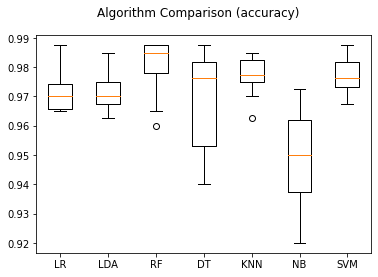

In [154]:
uncertainty_models = compare_models(new_X_2, y)

In [147]:
# compare_models(new_X_3, y)

In [148]:
# compare_models(newer_X, y)

In [149]:
# compare_models(newerer_X, y)

In [163]:
rf = RandomForestClassifier()

In [165]:
rf.fit(new_X_2, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<BarContainer object of 15 artists>

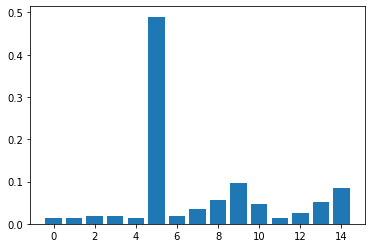

In [170]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

In [180]:
pickle.dump(rf, open("model_folder/rf_uncertainty_model.sav", "wb"))

In [181]:
loaded_model = pickle.load(open("model_folder/rf_uncertainty_model.sav", "rb"))

In [189]:
loaded_model.predict(new_X_2[2400].unsqueeze(dim=0))

array([0.], dtype=float32)

In [194]:
new_X_2[:1000]

tensor([[8.9929e-01, 9.9573e-02, 9.0154e-04,  ..., 4.1825e-02, 3.1471e-02, 4.1875e-03],
        [9.9999e-01, 5.5784e-06, 3.4120e-06,  ..., 1.6639e-03, 1.8648e-03, 2.2808e-03],
        [9.9891e-01, 1.0117e-03, 5.4842e-05,  ..., 6.9504e-02, 6.0276e-03, 1.2839e-02],
        ...,
        [9.9633e-01, 2.2126e-03, 8.1524e-04,  ..., 7.8321e-02, 3.1250e-02, 3.9159e-02],
        [9.2998e-01, 2.5413e-02, 1.6126e-02,  ..., 7.0538e-02, 1.1198e-01, 6.7571e-02],
        [9.8987e-01, 5.3030e-03, 1.4580e-03,  ..., 4.5461e-02, 2.5840e-02, 1.9282e-02]])